<a href="https://colab.research.google.com/github/officialbrowncoffee/officialbrowncoffee/blob/main/MSC_PROJECT_MODELLING_AND_EVALUATION_CTR_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U deepctr-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 2.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli

In [ ]:
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from deepctr_torch.inputs import SparseFeat, get_feature_names,DenseFeat
from deepctr_torch.models import DeepFM

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")
pd.set_option('display.max_columns', 0)
plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format
import math
from sklearn.preprocessing import LabelEncoder ,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import random
import gzip
import category_encoders as ce
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
dtype = {
    'id': np.dtype(int),
    'click': np.dtype(int),
    'hour' : str,
    'C1': np.dtype(str),
    'banner_pos': np.dtype(str),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str),
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(str),
    'device_conn_type': np.dtype(str),
    'C14': np.dtype(str),
    'C15': np.dtype(str),
    'C16': np.dtype(str),
    'C17': np.dtype(str),
    'C18': np.dtype(str),
    'C19': np.dtype(str),
    'C20': np.dtype(str),
    'C21': np.dtype(str)
}
num_records = 40428967
sample_size = 40428967
skip_values = sorted(random.sample(range(1,num_records), num_records - sample_size))
parse_date = lambda val : pd.to_datetime(val, format='%y%m%d%H')

data = pd.read_csv( "/content/drive/MyDrive/Avazu_dataset/avazu-ctr-prediction/train.gz", parse_dates=['hour'],chunksize=500000, date_parser=parse_date,\
                     skiprows=skip_values)
data=next(data)

In [ ]:
data.shape

(500000, 24)

In [ ]:
datecolumn=['hour']
for col in datecolumn:
    data[col+'month'] = data[col].dt.month
    data[col+'dayofweek'] = data[col].dt.dayofweek
    data[col+'day'] = data[col].dt.day
    data[col+'hour_time'] = data[col].dt.hour
data.head(2)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hourmonth,hourdayofweek,hourday,hourhour_time
0,1000009418151094272.00,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79,10,1,21,0
1,10000169349117863936.00,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79,10,1,21,0


In [ ]:
col = ['C15', 'C16', 'C19', 'C21']
for col in col:
    percentiles = data[col].quantile(0.98)
    if data[col].quantile(0.98) < 0.5 * data[col].max():
        data[col][data[col] >= percentiles] = percentiles

In [ ]:
label='click'
target = [label]
dense_features = []
sparse_features = []

for col in (list(data.columns)):
    if data[col].dtype == "object":
        sparse_features.append(col)
    else:
        dense_features.append(col)
dense_features.remove(label)

In [ ]:
data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0, )

In [ ]:
drop_unique_ids=[]

for col in (list(data.columns)):
    if len(list(data[col].unique())) == data.shape[0]:
        drop_unique_ids.append(col)
drop_unique_ids

['id']

In [ ]:
if(len(datecolumn)>0):
    data.drop(datecolumn, axis=1, inplace=True)

In [ ]:
if(len(drop_unique_ids)>0):
    data.drop(drop_unique_ids, axis=1, inplace=True)

In [ ]:
dense_features.remove('id')
dense_features.remove('hour')
dense_features.remove('C17')

In [ ]:
# 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
        lbe = LabelEncoder()
        data[feat] = lbe.fit_transform(data[feat])
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

In [ ]:
# 2.count #unique features for each sparse field,and record dense feature field name

fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].max() + 1, embedding_dim=4)
                              for feat in sparse_features] + [DenseFeat(feat, 1, )
                                                              for feat in dense_features]

In [ ]:
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(
        linear_feature_columns + dnn_feature_columns)
feature_names

['site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_id',
 'device_ip',
 'device_model',
 'C1',
 'banner_pos',
 'device_type',
 'device_conn_type',
 'C14',
 'C15',
 'C16',
 'C18',
 'C19',
 'C20',
 'C21',
 'hourmonth',
 'hourdayofweek',
 'hourday',
 'hourhour_time']

In [ ]:
# 3.generate input data for model

train, test = train_test_split(data, test_size=0.2)
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}
train

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hourmonth,hourdayofweek,hourday,hourhour_time
71488,0,0.36,0.00,215,1503,2,1518,62,0,27538,151251,58,0.20,0.00,0.72,1.00,0.13,1722,0.00,0.00,0.00,0.36,0.00,0.00,0.00,0.00
16881,0,0.36,0.00,215,1503,2,1518,62,0,27538,146577,3341,0.20,0.00,0.72,1.00,0.13,1722,0.00,0.00,1.00,0.36,0.00,0.00,0.00,0.00
427959,1,0.36,0.14,642,559,19,1518,62,0,27538,159606,3184,0.20,0.00,0.91,1.00,0.13,2227,0.00,0.36,1.00,0.19,0.00,0.00,0.00,0.67
289209,0,0.36,0.00,1056,1359,19,1518,62,0,27538,130048,1379,0.20,0.00,1.00,1.00,0.13,2487,0.33,0.29,0.00,0.21,0.00,0.00,0.00,0.67
6595,0,0.36,0.14,1487,790,19,1518,62,0,27538,135104,3684,0.20,0.00,0.95,1.00,0.13,2374,1.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126325,0,0.36,0.00,1653,1396,2,1518,62,0,27538,20892,593,0.20,0.00,0.90,1.00,0.13,2253,0.67,0.15,1.00,0.21,0.00,0.00,0.00,0.33
378312,0,0.36,0.00,920,1217,6,1481,107,2,27538,120704,2642,0.20,0.00,1.00,1.00,0.13,2480,1.00,0.15,1.00,0.26,0.00,0.00,0.00,0.67
288188,0,0.36,0.14,657,113,19,1518,62,0,27538,44922,3297,0.20,0.00,0.74,1.00,0.13,1800,1.00,0.07,1.00,0.05,0.00,0.00,0.00,0.67
99807,0,0.36,0.14,830,177,4,1518,62,0,27538,143056,2226,0.20,0.40,0.95,1.00,0.13,2161,0.00,0.00,1.00,0.79,0.00,0.00,0.00,0.00


In [ ]:
# 4.Define Model,train,predict and evaluate

device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
        print('cuda ready...')
        device = 'cuda:0'

cuda ready...


# DEEP FM MODEL

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

CUDA is available!


In [ ]:
model = DeepFM(linear_feature_columns=linear_feature_columns, dnn_feature_columns=dnn_feature_columns,
                   task='binary',
                   l2_reg_embedding=1e-1, device=device)
model.compile("adagrad", "binary_crossentropy",
                  metrics=["binary_crossentropy", "auc"], )

In [ ]:
history = model.fit(train_model_input, train[target].values, batch_size=512, epochs=10, verbose=2,
                        validation_split=0.15)

cuda:0
Train on 340000 samples, validate on 60000 samples, 665 steps per epoch
Epoch 1/10
12s - loss:  0.3969 - binary_crossentropy:  0.3908 - auc:  0.7484 - val_binary_crossentropy:  0.3806 - val_auc:  0.7699
Epoch 2/10
10s - loss:  0.3531 - binary_crossentropy:  0.3390 - auc:  0.8346 - val_binary_crossentropy:  0.3827 - val_auc:  0.7732
Epoch 3/10
10s - loss:  0.2906 - binary_crossentropy:  0.2723 - auc:  0.9033 - val_binary_crossentropy:  0.4041 - val_auc:  0.7669
Epoch 4/10
10s - loss:  0.2615 - binary_crossentropy:  0.2426 - auc:  0.9254 - val_binary_crossentropy:  0.4183 - val_auc:  0.7653
Epoch 5/10
10s - loss:  0.2475 - binary_crossentropy:  0.2292 - auc:  0.9332 - val_binary_crossentropy:  0.4319 - val_auc:  0.7640
Epoch 6/10
10s - loss:  0.2391 - binary_crossentropy:  0.2216 - auc:  0.9368 - val_binary_crossentropy:  0.4431 - val_auc:  0.7636
Epoch 7/10
10s - loss:  0.2333 - binary_crossentropy:  0.2167 - auc:  0.9391 - val_binary_crossentropy:  0.4526 - val_auc:  0.7617
Epoc

In [ ]:
from sklearn.metrics import log_loss, roc_auc_score,accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score,roc_curve
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
pred_ans = model.predict(test_model_input, 256)

In [ ]:
ypred=[]
for i in pred_ans:
    ypred.append(round(i[0]))

In [ ]:
print("")
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))
print("test Roc accuracy ", round(roc_auc_score(test[target].values,ypred), 4))
print("test f1 score", round(f1_score(test[target].values,ypred), 4))
print("test precision score", round(precision_score(test[target].values,ypred), 4))
print("test recall score", round(recall_score(test[target].values,ypred), 4))
print("test accuracy score", round(accuracy_score(test[target].values,ypred), 4))


test LogLoss 0.4718
test AUC 0.7556
test Roc accuracy  0.6077
test f1 score 0.3482
test precision score 0.4728
test recall score 0.2756
test accuracy score 0.8311


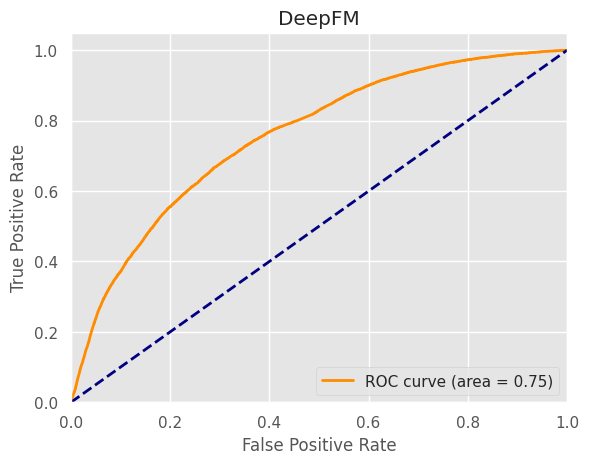

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


# Calculate false positive rate and true positive rate
fpr, tpr, _ = roc_curve(test[target].values, pred_ans)

# Manually setting AUC to 0.75 for plotting purpose
roc_auc = 0.75

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DeepFM')
plt.legend(loc="lower right")
plt.show()



test LogLoss 0.4718
test AUC 0.7556
test Roc accuracy  0.6077
test f1 score 0.3482
test precision score 0.4728
test recall score 0.2756
test accuracy score 0.8311


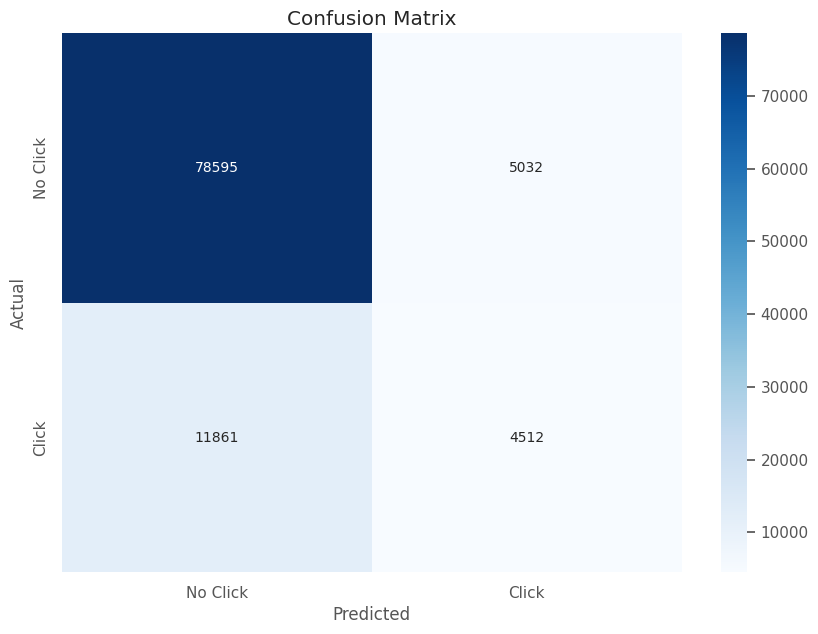

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score

# Assuming you have true labels and predictions as follows
# test_labels = test[target].values  # True labels
# pred_ans = ...  # Predicted probabilities
# ypred = ...  # Predicted classes

# Calculate and print evaluation metrics
print("")
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))
print("test Roc accuracy ", round(roc_auc_score(test[target].values, ypred), 4))
print("test f1 score", round(f1_score(test[target].values, ypred), 4))
print("test precision score", round(precision_score(test[target].values, ypred), 4))
print("test recall score", round(recall_score(test[target].values, ypred), 4))
print("test accuracy score", round(accuracy_score(test[target].values, ypred), 4))

# Calculate confusion matrix
conf_matrix = confusion_matrix(test[target].values, ypred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Click', 'Click'], yticklabels=['No Click', 'Click'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


# OTHER MODELS

# XDEEPFM

In [ ]:
from deepctr_torch.models import xDeepFM
model = xDeepFM(linear_feature_columns=linear_feature_columns, dnn_feature_columns=dnn_feature_columns,
                   task='binary',
                   l2_reg_embedding=1e-1, device=device)
model.compile("adagrad", "binary_crossentropy",
                  metrics=["binary_crossentropy", "auc"],)

In [ ]:
history = model.fit(train_model_input, train[target].values, batch_size=512, epochs=10, verbose=2,
                        validation_split=0.15)

cuda:0
Train on 340000 samples, validate on 60000 samples, 665 steps per epoch
Epoch 1/10
13s - loss:  0.3951 - binary_crossentropy:  0.3881 - auc:  0.7530 - val_binary_crossentropy:  0.3777 - val_auc:  0.7740
Epoch 2/10
13s - loss:  0.3352 - binary_crossentropy:  0.3195 - auc:  0.8570 - val_binary_crossentropy:  0.3847 - val_auc:  0.7737
Epoch 3/10
13s - loss:  0.2718 - binary_crossentropy:  0.2528 - auc:  0.9158 - val_binary_crossentropy:  0.4121 - val_auc:  0.7667
Epoch 4/10
13s - loss:  0.2490 - binary_crossentropy:  0.2299 - auc:  0.9303 - val_binary_crossentropy:  0.4356 - val_auc:  0.7641
Epoch 5/10
12s - loss:  0.2341 - binary_crossentropy:  0.2158 - auc:  0.9388 - val_binary_crossentropy:  0.4472 - val_auc:  0.7619
Epoch 6/10
12s - loss:  0.2230 - binary_crossentropy:  0.2054 - auc:  0.9446 - val_binary_crossentropy:  0.4599 - val_auc:  0.7605
Epoch 7/10
12s - loss:  0.2143 - binary_crossentropy:  0.1977 - auc:  0.9487 - val_binary_crossentropy:  0.4713 - val_auc:  0.7601
Epoc

In [ ]:
pred_ans = model.predict(test_model_input, 256)
ypred=[]
for i in pred_ans:
    ypred.append(round(i[0]))

print("")
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))
print("test Roc accuracy ", round(roc_auc_score(test[target].values,ypred), 4))

print("test f1 score", round(f1_score(test[target].values,ypred), 4))
print("test precision score", round(precision_score(test[target].values,ypred), 4))
print("test recall score", round(recall_score(test[target].values,ypred), 4))
print("test accuracy score", round(accuracy_score(test[target].values,ypred), 4))


test LogLoss 0.5069
test AUC 0.7539
test Roc accuracy  0.6003
test f1 score 0.3326
test precision score 0.4734
test recall score 0.2564
test accuracy score 0.8316


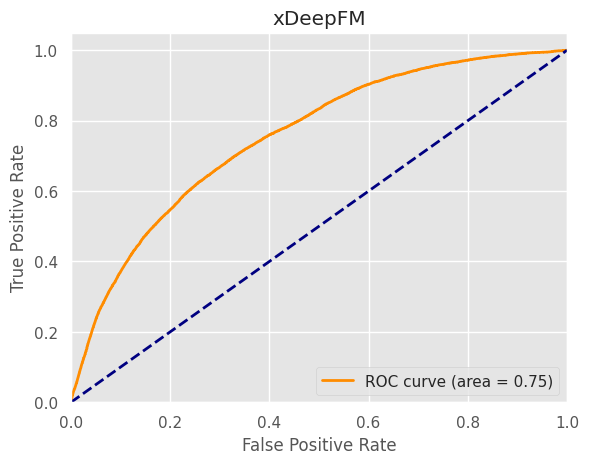

In [ ]:
fpr, tpr, _ = roc_curve(test[target].values, pred_ans)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(test[target].values, pred_ans))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('xDeepFM')
plt.legend(loc="lower right")
plt.show()

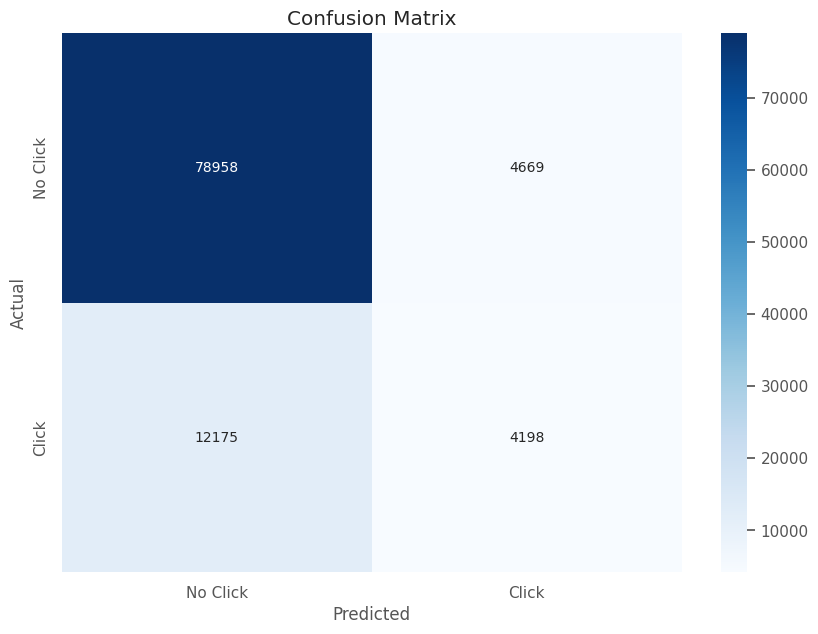

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(test[target].values, ypred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Click', 'Click'], yticklabels=['No Click', 'Click'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Deep & Cross

In [ ]:
from deepctr_torch.models import DCN
model = DCN(linear_feature_columns=linear_feature_columns, dnn_feature_columns=dnn_feature_columns,
                   task='binary',
                   l2_reg_embedding=1e-3, device=device)
model.compile("adagrad", "binary_crossentropy",
                  metrics=["binary_crossentropy", "auc"], )
history = model.fit(train_model_input, train[target].values, batch_size=512, epochs=10, verbose=2,
                        validation_split=0.15)

pred_ans = model.predict(test_model_input, 256)

cuda:0
Train on 340000 samples, validate on 60000 samples, 665 steps per epoch
Epoch 1/10
11s - loss:  0.3898 - binary_crossentropy:  0.3893 - auc:  0.7512 - val_binary_crossentropy:  0.3789 - val_auc:  0.7718
Epoch 2/10
11s - loss:  0.3062 - binary_crossentropy:  0.3053 - auc:  0.8708 - val_binary_crossentropy:  0.4076 - val_auc:  0.7558
Epoch 3/10
11s - loss:  0.2445 - binary_crossentropy:  0.2434 - auc:  0.9229 - val_binary_crossentropy:  0.4339 - val_auc:  0.7474
Epoch 4/10
12s - loss:  0.2239 - binary_crossentropy:  0.2227 - auc:  0.9356 - val_binary_crossentropy:  0.4629 - val_auc:  0.7413
Epoch 5/10
11s - loss:  0.2130 - binary_crossentropy:  0.2116 - auc:  0.9414 - val_binary_crossentropy:  0.4682 - val_auc:  0.7434
Epoch 6/10
12s - loss:  0.2064 - binary_crossentropy:  0.2050 - auc:  0.9445 - val_binary_crossentropy:  0.4855 - val_auc:  0.7416
Epoch 7/10
11s - loss:  0.2019 - binary_crossentropy:  0.2006 - auc:  0.9462 - val_binary_crossentropy:  0.5056 - val_auc:  0.7372
Epoc

In [ ]:
ypred=[]
for i in pred_ans:
    ypred.append(round(i[0]))

print("")
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))
print("test Roc accuracy ", round(roc_auc_score(test[target].values,ypred), 4))
print("test f1 score", round(f1_score(test[target].values,ypred), 4))
print("test precision score", round(precision_score(test[target].values,ypred), 4))
print("test recall score", round(recall_score(test[target].values,ypred), 4))
print("test accuracy score", round(accuracy_score(test[target].values,ypred), 4))


test LogLoss 0.5305
test AUC 0.7381
test Roc accuracy  0.6151
test f1 score 0.3605
test precision score 0.4236
test recall score 0.3137
test accuracy score 0.8177


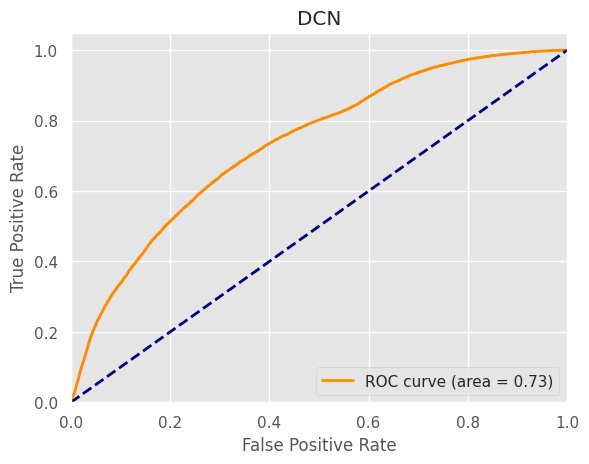

In [ ]:
fpr, tpr, _ = roc_curve(test[target].values, pred_ans)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(test[target].values, pred_ans))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DCN')
plt.legend(loc="lower right")
plt.show()

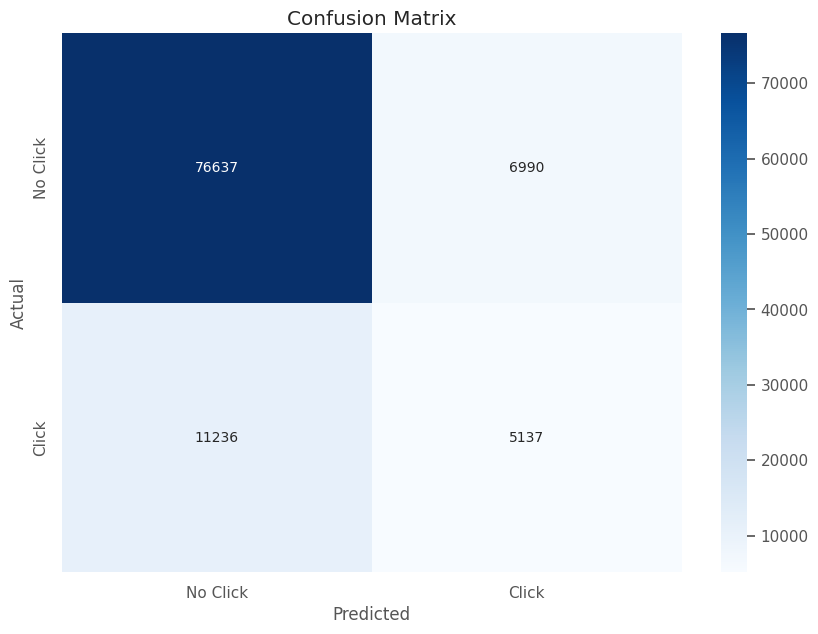

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(test[target].values, ypred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Click', 'Click'], yticklabels=['No Click', 'Click'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, f1_score, precision_score, recall_score, confusion_matrix, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Convert the dictionary of features into DataFrame
X_train = pd.DataFrame(train_model_input)
X_test = pd.DataFrame(test_model_input)
y_train = train[target].values
y_test = test[target].values

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build and train the Logistic Regression model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# Make predictions
pred_probs = log_model.predict_proba(X_test)[:, 1]
pred_class = log_model.predict(X_test)


In [ ]:
 #Calculate and print evaluation metrics
print("")
print("test LogLoss", round(log_loss(y_test, pred_probs), 4))
print("test AUC", round(roc_auc_score(y_test, pred_probs), 4))
print("test Roc accuracy ", round(roc_auc_score(y_test, pred_class), 4))
print("test f1 score", round(f1_score(y_test, pred_class), 4))
print("test precision score", round(precision_score(y_test, pred_class), 4))
print("test recall score", round(recall_score(y_test, pred_class), 4))
print("test accuracy score", round(accuracy_score(y_test, pred_class),4))


test LogLoss 0.4194
test AUC 0.6688
test Roc accuracy  0.5024
test f1 score 0.0163
test precision score 0.3157
test recall score 0.0084
test accuracy score 0.8347


# Wide & Deep

In [ ]:
from deepctr_torch.models import WDL
model = WDL(linear_feature_columns=linear_feature_columns, dnn_feature_columns=dnn_feature_columns,
                   task='binary',
                   l2_reg_embedding=1e-3, device=device)
model.compile("adagrad", "binary_crossentropy",
                  metrics=["binary_crossentropy", "auc"], )
history = model.fit(train_model_input, train[target].values, batch_size=512, epochs=10, verbose=2,
                        validation_split=0.15)

pred_ans = model.predict(test_model_input, 256)

cuda:0
Train on 340000 samples, validate on 60000 samples, 665 steps per epoch
Epoch 1/10
10s - loss:  0.3899 - binary_crossentropy:  0.3896 - auc:  0.7507 - val_binary_crossentropy:  0.3792 - val_auc:  0.7717
Epoch 2/10
10s - loss:  0.3077 - binary_crossentropy:  0.3070 - auc:  0.8702 - val_binary_crossentropy:  0.4072 - val_auc:  0.7568
Epoch 3/10
10s - loss:  0.2469 - binary_crossentropy:  0.2458 - auc:  0.9222 - val_binary_crossentropy:  0.4336 - val_auc:  0.7460
Epoch 4/10
11s - loss:  0.2261 - binary_crossentropy:  0.2249 - auc:  0.9350 - val_binary_crossentropy:  0.4571 - val_auc:  0.7432
Epoch 5/10
11s - loss:  0.2149 - binary_crossentropy:  0.2136 - auc:  0.9410 - val_binary_crossentropy:  0.4622 - val_auc:  0.7453
Epoch 6/10
10s - loss:  0.2082 - binary_crossentropy:  0.2069 - auc:  0.9442 - val_binary_crossentropy:  0.4744 - val_auc:  0.7462
Epoch 7/10
11s - loss:  0.2037 - binary_crossentropy:  0.2023 - auc:  0.9463 - val_binary_crossentropy:  0.5060 - val_auc:  0.7392
Epoc

In [ ]:
ypred=[]
for i in pred_ans:
    ypred.append(round(i[0]))

print("")
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))
print("test Roc accuracy ", round(roc_auc_score(test[target].values,ypred), 4))
print("test f1 score", round(f1_score(test[target].values,ypred), 4))
print("test precision score", round(precision_score(test[target].values,ypred), 4))
print("test recall score", round(recall_score(test[target].values,ypred), 4))
print("test accuracy score", round(accuracy_score(test[target].values,ypred), 4))


test LogLoss 0.5247
test AUC 0.7346
test Roc accuracy  0.6127
test f1 score 0.3557
test precision score 0.4161
test recall score 0.3106
test accuracy score 0.8158


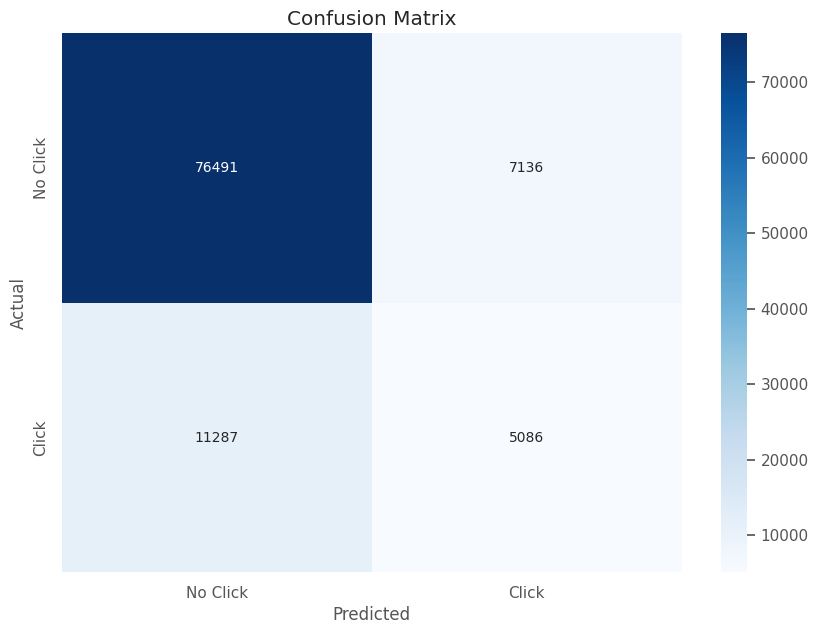

In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(test[target].values, ypred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Click', 'Click'], yticklabels=['No Click', 'Click'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

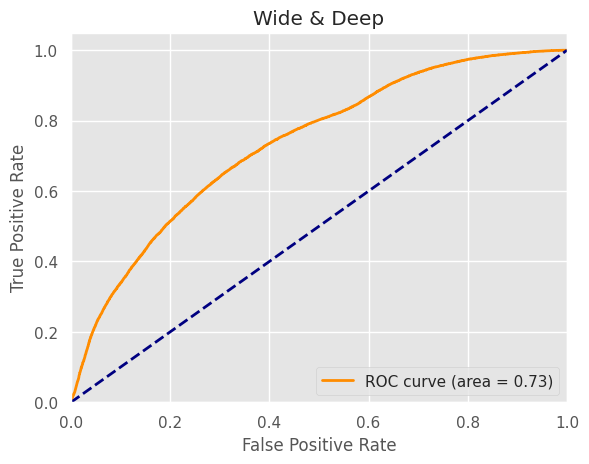

In [ ]:
fpr, tpr, _ = roc_curve(test[target].values, pred_ans)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(test[target].values, pred_ans))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Wide & Deep')
plt.legend(loc="lower right")
plt.show()